In [1]:
%load_ext autoreload
%autoreload 2

from importlib import reload
import datetime 

import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import quantstats as qs

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

plt.rcParams['figure.figsize'] = [6, 3]

In [2]:
import funcs
import strategy as strat

from strategy import *
from funcs import *

In [3]:
def add_ref_dates(df):
    df['refmonth'] = df['refdate'].apply(lambda x: x.strftime("%b").upper())
    df['refyear'] = df['refdate'].apply(lambda x: x.strftime("%Y"))
    df['refmonthyear'] = df['refdate'].apply(lambda x: x.strftime("%b.%Y").upper())

    df.drop(['refmonth', 'refyear'], axis=1, inplace=True)
    return df

In [4]:
dfcpi = pd.read_parquet("data/processed/cpi_all.pq")
dfcpi = funcs.filter_cols(dfcpi, "usa")
dfcpi.reset_index(inplace=True)

# X Matrix (features)

In [5]:
# Load bloomberg CPI & PMI data
#
dfbbg = pd.read_parquet("data/processed/bbg_cpi_ism.pq")
dfbbg['surprise'] = dfbbg['px_last'] - dfbbg['survey_mean']

dfbbglast = dfbbg.pivot(index=['ref_date', 'release_date'], 
                    columns='ticker', 
                    values=['px_last'])

dfbbgmean = dfbbg.pivot(index=['ref_date', 'release_date'], 
                    columns='ticker', 
                    values=['survey_mean'])

pmpmi = dfbbg[dfbbg['ticker'] == 'NAPMPMI']
pmnmi = dfbbg[dfbbg['ticker'] == 'NAPMNMI']
cpi = dfbbg[dfbbg['ticker'] == 'USA.CPI.YOY']

pmpmi.set_index('ref_date', inplace=True)
pmnmi.set_index('ref_date', inplace=True)
cpi.set_index('ref_date', inplace=True)

# Load FRED CPI / PMI data
#
cpi_fred = pd.read_csv("data/raw/cpi_fred.csv")
cpi_fred['date'] = cpi_fred['date'].apply(lambda x: pd.to_datetime(x))
cpi_fred.set_index('date', inplace=True)
cpi_fred['usa.cpi.yoy'] = cpi_fred['usa.cpi'].pct_change(12) * 100
cpi_fred['usa.cpi.mom'] = cpi_fred['usa.cpi'].pct_change(1) * 100

# Load SPY / AGG prices
#
spy_all = pd.read_csv("data/raw/spy_all.csv")
spy_all['date'] = spy_all['date'].apply(lambda x: pd.to_datetime(x))
spy_all = spy_all[['date', 'adjusted']]
spy_all.columns = ['date', 'spy']
spy_all.set_index('date', inplace=True)

agg_all = pd.read_csv("data/raw/agg_all.csv")
agg_all['date'] = agg_all['date'].apply(lambda x: pd.to_datetime(x))
agg_all = agg_all[['date', 'adjusted']]
agg_all.columns = ['date', 'agg']
agg_all.set_index('date', inplace=True)

df = pd.merge_asof(agg_all, spy_all, left_index=True, right_index=True, direction='backward')
df = pd.merge_asof(df, cpi_fred, left_index=True, right_index=True, direction='backward')
df.head()

,agg,spy,usa.cpi,usa.cpi.yoy,usa.cpi.mom
date,,,,,
2003-09-29,54.216270,68.516754,185.2,2.320442,0.325027
2003-09-30,54.497532,67.851486,185.2,2.320442,0.325027
2003-10-01,54.471027,69.297485,185.0,2.040816,-0.107991
2003-10-02,54.386044,69.548630,185.0,2.040816,-0.107991
2003-10-03,53.993420,70.186745,185.0,2.040816,-0.107991


In [6]:
dfbbg['refmonth'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%b").upper())
dfbbg['refyear'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%Y"))
dfbbg['refmonthyear'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%b.%Y").upper())

ticker_map = {'NAPMNMI': 'pmnmi', 'NAPMPMI': 'pmpmi', 'USA.CPI.YOY': 'cpiyoy'}
dfbbg['ticker'] = dfbbg['ticker'].apply(lambda x: ticker_map[x])
# dfbbg.drop(['survey_high', 'survey_low', 'survey_median'], axis=1, inplace=True)
dfbbg['refmonth'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%b").upper())
dfbbg['refyear'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%Y"))
dfbbg['refmonthyear'] = dfbbg['ref_date'].apply(lambda x: x.strftime("%b.%Y").upper())

dfbbg = dfbbg[['ticker', 'ref_date', 'release_date', 'refmonth', 'refyear', 'refmonthyear', 'px_last', 'survey_mean', 'surprise']]

dfbbg_actual = pd.pivot(dfbbg, index=['refmonthyear'], columns='ticker', values='px_last')

dfcpi_surprise = pd.pivot(dfbbg, index=['refmonthyear'], columns='ticker', values='surprise')['cpiyoy'].to_frame()
dfcpi_surprise.columns = ['cpiyoy.surprise']

In [7]:
dfcpi = pd.read_parquet("data/processed/cpi_all.pq")
# dfcpi = funcs.filter_cols(dfcpi, "usa")
# dfcpi.reset_index(inplace=True)
# dfcpi['pubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
# dfcpi['index'] = dfcpi['pubdate'].copy()
# # dfcpi['adjpubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
# dfcpi = dfcpi.set_index('index')

dfism_man = pd.read_parquet("data/processed/ism_man.pq")
# dfism_man = funcs.filter_cols(dfism_man, "usa")
# dfism_man.reset_index(inplace=True)
# dfism_man['pubdate'] = dfism_man['usa.ism.man.pubdate'].apply(funcs.adj_date)
# dfism_man['index'] = dfism_man['pubdate'].copy()
# dfism_man = dfism_man.set_index('index')

dfism_nonman = pd.read_parquet("data/processed/ism_nonman.pq")
# dfism_nonman.reset_index(inplace=True)
# dfism_nonman['pubdate'] = dfism_nonman['usa.ism.nonman.pubdate'].apply(funcs.adj_date)
# dfism_nonman['index'] = dfism_nonman['pubdate'].copy()
# dfism_nonman = dfism_nonman.set_index('index')
# dfism_nonman = funcs.filter_cols(dfism_nonman, "usa")

cpi_cols = ['refdate', 'pubdate'] + [f'usa.tlbt.cpi.yoy.nsa.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cpi.yoy.nsa.date.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.cpi.yoy.nsa.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.cpi.yoy.nsa.date.{n}m' for n in [1,3,6,9,12]]
nmi_cols = ['refdate', 'pubdate'] + [f'usa.tlbt.ism.nonman.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.ism.nonman.date.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.ism.nonman.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.ism.nonman.date.{n}m' for n in [1,3,6,9,12]]
pmi_cols = ['refdate', 'pubdate'] + [f'usa.tlbt.ism.man.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.ism.man.date.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.ism.man.{n}m' for n in [1,3,6,9,12]] + [f'usa.tlbt.cons.ism.man.date.{n}m' for n in [1,3,6,9,12]]

tlbtcpi = dfcpi[cpi_cols].copy()
tlbtnmi = dfism_nonman[nmi_cols].copy()
tlbtpmi = dfism_man[pmi_cols].copy()

tlbtcpi = add_ref_dates(tlbtcpi)
tlbtnmi = add_ref_dates(tlbtnmi)
tlbtpmi = add_ref_dates(tlbtpmi)
# tlbtpmi = dfism_nonman

tlbtcpi.reset_index(inplace=True); tlbtcpi.drop('index', inplace=True, axis=1)
tlbtnmi.reset_index(inplace=True); tlbtnmi.drop('index', inplace=True, axis=1); 
tlbtpmi.reset_index(inplace=True); tlbtpmi.drop('index', inplace=True, axis=1)

# NMI data has duplicate entry for Ref Month Feb 2023, removing for feature construction
tlbtnmi = tlbtnmi.groupby('refmonthyear').first().reset_index()
# print(len(tlbtnmi.index), len(tlbtnmi.index.unique()))

tlbtcpi.set_index('refmonthyear', inplace=True)
tlbtnmi.set_index('refmonthyear', inplace=True)
tlbtpmi.set_index("refmonthyear", inplace=True)

print(len(tlbtnmi.index), len(tlbtnmi.index.unique()))

tlbtcpi.columns = ['cpirefdate', 'cpipubdate', 'cpiyoy1m', 'cpiyoy3m', 'cpiyoy6m', 'cpiyoy9m', 'cpiyoy12m', 'cpiyoy1mdt', 'cpiyoy3mdt', 'cpiyoy6mdt', 'cpiyoy9mdt', 'cpiyoy12mdt', 'cpiyoycons1m', 'cpiyoycons3m', 'cpiyoycons6m', 'cpiyoycons9m', 'cpiyoycons12m', 'cpiyoycons1mdt', 'cpiyoycons3mdt', 'cpiyoycons6mdt', 'cpiyoycons9mdt', 'cpiyoycons12mdt']
tlbtnmi.columns = ['nmirefdate', 'nmipubdate', 'nmi1m', 'nmi3m', 'nmi6m', 'nmi9m', 'nmi12m', 'nmi1mdt', 'nmi3mdt', 'nmi6mdt', 'nmi9mdt', 'nmi12mdt', 'nmicons1m', 'nmicons3m', 'nmicons6m', 'nmicons9m', 'nmicons12m', 'nmicons1mdt', 'nmicons3mdt', 'nmicons6mdt', 'nmicons9mdt', 'nmicons12mdt']
tlbtpmi.columns = ['pmirefdate', 'pmipubdate', 'pmi1m', 'pmi3m', 'pmi6m', 'pmi9m', 'pmi12m', 'pmi1mdt', 'pmi3mdt', 'pmi6mdt', 'pmi9mdt', 'pmi12mdt', 'pmicons1m', 'pmicons3m', 'pmicons6m', 'pmicons9m', 'pmicons12m', 'pmicons1mdt', 'pmicons3mdt', 'pmicons6mdt', 'pmicons9mdt', 'pmicons12mdt']

dfcpi = dfcpi[[c for c in dfcpi.columns if ('mom' not in c) and ('.sa' not in  c)]]

dfcpi = add_ref_dates(dfcpi)
dfism_man = add_ref_dates(dfism_man)
dfism_nonman = add_ref_dates(dfism_nonman)

tlbtcpi['cpiyoyact'] = dfbbg_actual['cpiyoy']
tlbtnmi['nmiact'] = dfbbg_actual['pmnmi']
tlbtpmi['pmiact'] = dfbbg_actual['pmpmi']

132 132


In [8]:
dfX = pd.merge(tlbtcpi, tlbtnmi, left_index=True, right_index=True, how='inner')
dfX = pd.merge(dfX, tlbtpmi, left_index=True, right_index=True, how='inner')
dfX.sort_values('cpirefdate', inplace=True)

In [9]:
dfX.reset_index(inplace=True)
dfX.drop_duplicates(inplace=True)
dfX.set_index('refmonthyear', inplace=True)

head(dfX)

,cpirefdate,cpipubdate,cpiyoy1m,cpiyoy3m,cpiyoy6m,cpiyoy9m,cpiyoy12m,cpiyoy1mdt,cpiyoy3mdt,cpiyoy6mdt,...,pmicons3m,pmicons6m,pmicons9m,pmicons12m,pmicons1mdt,pmicons3mdt,pmicons6mdt,pmicons9mdt,pmicons12mdt,pmiact
refmonthyear,,,,,,,,,,,,,,,,,,,,,
JAN.2013,2013-01-31,2013-02-26,1.541966,1.207702,2.134584,2.414804,3.568,2013-02-28,2013-04-30,2013-07-31,...,50.500000,50.750000,50.955556,51.666667,2013-02-28,2013-04-30,2013-07-31,2013-10-31,2014-01-31,53.3
FEB.2013,2013-02-28,2013-03-20,1.474452,1.611961,2.126072,2.909134,3.375,2013-03-31,2013-05-31,2013-08-31,...,52.433333,51.400000,51.088889,51.758333,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-02-28,54.2
MAR.2013,2013-03-31,2013-04-19,1.178381,1.544404,1.913064,2.018203,2.957,2013-04-30,2013-06-30,2013-09-30,...,53.333333,51.516667,51.288889,51.666667,2013-04-30,2013-06-30,2013-09-30,2013-12-31,2014-03-31,51.9
APR.2013,2013-04-30,2013-05-21,1.361924,2.045935,1.936189,2.425523,3.497,2013-05-31,2013-07-31,2013-10-31,...,52.500000,51.500000,51.333333,51.341667,2013-05-31,2013-07-31,2013-10-31,2014-01-31,2014-04-30,51.0
MAY.2013,2013-05-31,2013-06-21,1.669177,1.748812,2.522877,2.405458,3.303,2013-06-30,2013-08-31,2013-11-30,...,51.033333,51.733333,51.277778,51.075000,2013-06-30,2013-08-31,2013-11-30,2014-02-28,2014-05-31,50.8


# Returns processing

In [10]:
dfetfs = pd.read_parquet("data/processed/etfs.pq")
dfref = pd.read_csv("data/processed/etfref.csv")
dfref.set_index('ticker', inplace=True)
idx = pd.DatetimeIndex(dfetfs.date.values)
dfetfs = dfetfs.set_index(idx)

mindate = datetime.date(2012, 1, 1) # minimum data date for analysis
mints = pd.Timestamp(pd.to_datetime(mindate)) # minimum timestamp for analysis 

etfs2keep = ['SPY', 'AGG',  # sp500, Agg bond etf
            'XOP', 'XME', 'XHB', 'GLD',  # Oil & Gas, Metals & Mining, Homebuilders, Gold Shares
            'BIL', 'TIP', 'SPTS', 'SPTI'] # 1-3Mth TBills, TIPs, Short Term Tsy, Med. Term Tsy

# etfs2keep = dfetfs.ticker.unique()
etfs2keep = []
for ticker in dfetfs.ticker.unique():
    firstdate = dfetfs[dfetfs.ticker == ticker].dropna().index[0]
    firstdate = pd.to_datetime(firstdate).date()
    if firstdate <= mindate:
        etfs2keep.append(ticker)

# dfcloses = dfetfs[dfetfs['date'].apply(pd.to_datetime) > mints]
dfcloses = dfetfs.pivot(columns='ticker', values='adjusted')[etfs2keep].dropna()
dfcloses = dfcloses[dfcloses.index >= pd.Timestamp(mindate)]
dfcloses = dfcloses.pct_change()
zeros = np.zeros(shape=(1, dfcloses.shape[1]))
dfcloses.iloc[0] = zeros
dfcloses = dfcloses.dropna()
dftotrtn = dfcloses.apply(lambda x: 100*np.cumprod(1 + x))

## Create 60/40 Portfolio & Naive Vol Weight Portfolio

In [11]:
weights = {'SPY': .6, 'AGG': .4}
weights = make_fixed_weights(weights, dftotrtn)
index6040 = make_index(dftotrtn, weights)

tickers = ['SPY', 'AGG', 'GLD']
vol_weights = make_vol_weights(dftotrtn[tickers], window=30)
vol_tr = make_index(dftotrtn[tickers], vol_weights).dropna()

## Y matrix

In [12]:
# Monthly volatilities (STDevs) -- maybe this is the forecast target? 
stdev_30d = (dftotrtn.pct_change()
             .rolling(window=30, min_periods=30)
             .std()
             .dropna()
             .apply(lambda x: np.round(x * 100 * np.sqrt(252), 2)))


# Create dfY - matrix of monthly returns per etf symbol
dfY = dftotrtn.copy()
dfY.columns = [f"{c.lower()}" for c in dfY.columns]
dfY['naivevol'] = vol_tr
dfY['6040'] = index6040

dfY_mth = None 
for c in dfY.columns:
    returns = dfY[c].resample('1M').agg('ohlc')['close'] / dfY[c].resample('1M').agg('ohlc')['open'] - 1
    if dfY_mth is None:
        dfY_mth = returns.to_frame(name=c)
    else:
        dfY_mth[c] = returns

dfY_mth['date'] = dfY_mth.index.values
dfY_mth['refmonthyear'] = dfY_mth['date'].apply(lambda x: x.strftime("%b.%Y").upper())
dfY_mth.drop('date', axis=1, inplace=True)

dfY_mth = dfY_mth.reset_index().drop_duplicates().set_index('refmonthyear') #.drop('index', axis=1) #, inplace=True)
dfY_mth = dfY_mth.drop('index', axis=1)
dfY = dfY_mth
del(dfY_mth)

# # dfY.set_index("refmonthyear", inplace=True)

# dfY = dfY.loc[dfX.index]
head(dfY)

,bnd,agg,tlt,vcit,vcsh,bil,bsv,lqd,ief,shy,...,sgol,dbc,uso,gsg,ung,boil,agq,dbo,naivevol,6040
refmonthyear,,,,,,,,,,,,,,,,,,,,,
JAN.2012,0.009486,0.009270,0.011890,0.026270,0.013706,0.000000,0.005690,0.022258,0.015062,0.001420,...,0.085209,0.006874,-0.047115,-0.011417,-0.188563,-3.576678e-01,0.238574,-0.033030,NaN,0.021684
FEB.2012,0.001432,0.001628,-0.014683,0.007706,0.010089,0.000218,-0.000862,0.012299,-0.007553,-0.001065,...,-0.030952,0.050143,0.094703,0.062815,0.018317,6.661338e-16,0.032852,0.095037,0.001398,0.021501
MAR.2012,-0.003470,-0.003718,-0.033259,-0.007574,-0.001099,0.000000,-0.001727,-0.011879,-0.012714,-0.000593,...,-0.027315,-0.032908,-0.060359,-0.045292,-0.185678,-3.327386e-01,-0.177838,-0.055871,0.002405,0.015129
APR.2012,0.011084,0.008940,0.042567,0.015767,0.003974,0.000436,0.003710,0.008224,0.022641,0.001778,...,-0.006865,-0.026054,-0.008743,-0.020627,0.012963,-2.069858e-02,-0.120641,-0.009839,-0.002263,-0.005340
MAY.2012,0.010764,0.011149,0.095938,0.003570,-0.001109,0.000000,0.001604,0.009494,0.030570,0.000592,...,-0.059900,-0.111580,-0.187796,-0.130072,-0.006509,-5.544304e-02,-0.203629,-0.191225,-0.009886,-0.036729


In [81]:
print(len(dfY.index), len(dfY.index.unique()))
print(len(dfX.index), len(dfX.index.unique()))

144 144
132 132


# Write X, Y to disk

In [82]:
dfX.to_parquet("data/workspace/dfX.pq")
dfY.to_parquet("data/workspace/dfY.pq")

dftotrtn.to_parquet("data/workspace/dftotrtn.pq")

# Merge Turnleaf Data

In [25]:
dfX

,cpirefdate,cpipubdate,cpiyoy1m,cpiyoy3m,cpiyoy6m,cpiyoy9m,cpiyoy12m,cpiyoy1mdt,cpiyoy3mdt,cpiyoy6mdt,...,pmicons3m,pmicons6m,pmicons9m,pmicons12m,pmicons1mdt,pmicons3mdt,pmicons6mdt,pmicons9mdt,pmicons12mdt,pmiact
refmonthyear,,,,,,,,,,,,,,,,,,,,,
APR.2013,2013-04-30,2013-05-21,1.361924,2.045935,1.936189,2.425523,3.49700,2013-05-31,2013-07-31,2013-10-31,...,52.500000,51.500000,51.333333,51.341667,2013-05-31,2013-07-31,2013-10-31,2014-01-31,2014-04-30,51.0
APR.2014,2014-04-30,2014-05-20,2.067818,1.659554,2.370570,2.605932,2.04000,2014-05-31,2014-07-31,2014-10-31,...,55.100000,54.883333,55.077778,54.333333,2014-05-31,2014-07-31,2014-10-31,2015-01-31,2015-04-30,56.6
APR.2015,2015-04-30,2015-05-27,-0.143089,-0.426827,-0.466850,2.481655,1.75800,2015-05-31,2015-07-31,2015-10-31,...,52.400000,53.916667,54.966667,55.116667,2015-05-31,2015-07-31,2015-10-31,2016-01-31,2016-04-30,51.9
APR.2016,2016-04-30,2016-05-20,1.157585,1.163650,1.650565,1.800750,1.29100,2016-05-31,2016-07-31,2016-10-31,...,50.700000,49.450000,49.677778,50.433333,2016-05-31,2016-07-31,2016-10-31,2017-01-31,2017-04-30,51.3
APR.2017,2017-04-30,2017-05-17,1.910023,2.077399,1.960446,1.512517,2.05200,2017-05-31,2017-07-31,2017-10-31,...,56.566667,55.600000,54.044444,53.625000,2017-05-31,2017-07-31,2017-10-31,2018-01-31,2018-04-30,55.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEP.2019,2019-09-30,2019-10-15,1.681174,1.938943,1.723035,1.319078,1.93800,2019-10-31,2019-12-31,2020-03-31,...,49.366667,50.783333,52.311111,53.491667,2019-10-31,2019-12-31,2020-03-31,2020-06-30,2020-09-30,48.1
SEP.2020,2020-09-30,2020-10-13,1.293832,1.024179,1.268347,1.382158,1.94300,2020-10-31,2020-12-31,2021-03-31,...,55.166667,50.450000,50.311111,49.700000,2020-10-31,2020-12-31,2021-03-31,2021-06-30,2021-09-30,55.5
SEP.2021,2021-09-30,2021-10-13,5.817536,7.385445,8.286777,5.863815,5.93000,2021-10-31,2021-12-31,2022-03-31,...,60.166667,60.500000,60.800000,60.350000,2021-10-31,2021-12-31,2022-03-31,2022-06-30,2022-09-30,60.7


In [ ]:
# usa.ism.nonman.refdate, usa.ism.nonman.pubdate 
# usa.ism.man.refdate, usa.ism.man.pubdate, pubdate
# usa.cpi.yoy.nsa.pubdate, usa.cpi.yoy.nsa.refdate, 
# usa.cpi.mom.nsa.pubdate, usa.cpi.mom.nsa.refdate, usa.cpi.mom.sa.pubdate, usa.cpi.mom.sa.refdate
# pubdate


# Feature Generation

In [16]:
head(dfbbg)

,ticker,ref_date,release_date,px_last,survey_median,survey_mean,survey_high,survey_low,surprise,refmonth,refyear,refmonthyear
0,NAPMPMI,1980-07-31,NaT,35.0,NaN,NaN,NaN,NaN,NaN,JUL,1980,JUL.1980
1,NAPMPMI,1980-08-31,NaT,45.5,NaN,NaN,NaN,NaN,NaN,AUG,1980,AUG.1980
2,NAPMPMI,1980-09-30,NaT,50.1,NaN,NaN,NaN,NaN,NaN,SEP,1980,SEP.1980
3,NAPMPMI,1980-10-31,NaT,55.5,NaN,NaN,NaN,NaN,NaN,OCT,1980,OCT.1980
4,NAPMPMI,1980-11-30,NaT,58.2,NaN,NaN,NaN,NaN,NaN,NOV,1980,NOV.1980


In [145]:
dfbbg_actual

ticker,cpiyoy,pmnmi,pmpmi
refmonthyear,,,
APR.1981,10.0,NaN,51.6
APR.1982,6.5,NaN,37.8
APR.1983,3.9,NaN,54.2
APR.1984,4.6,NaN,61.0
APR.1985,3.7,NaN,48.2
...,...,...,...
SEP.2019,1.7,53.2,48.1
SEP.2020,1.4,57.1,55.5
SEP.2021,5.4,62.1,60.7


In [229]:
dftotrtn

ticker,BND,AGG,TLT,VCIT,VCSH,BIL,BSV,LQD,IEF,SHY,...,FTGC,DBC,USO,GSG,UNG,OUNZ,BOIL,AGQ,DBO,RINF
2016-12-14,99.491316,99.453104,98.882703,99.379710,99.785646,100.000000,99.698179,99.364005,99.168856,99.810549,...,99.489658,99.047016,96.504690,98.396408,102.866972,98.560210,105.804907,98.683490,96.897606,102.664797
2016-12-15,99.342411,99.332596,99.382102,99.169088,99.609034,100.000000,99.635271,99.432751,98.891800,99.763124,...,98.892636,98.919960,96.845696,98.332263,99.082570,97.382197,99.341712,89.166207,97.104444,100.455809
2016-12-16,99.429244,99.397470,99.153568,99.239295,99.684699,99.978081,99.660462,99.355401,99.015933,99.810549,...,99.085209,99.364691,98.465479,99.230277,98.050458,97.818499,97.606224,90.263304,98.759034,99.789613
2016-12-19,99.689787,99.657033,100.220086,99.625464,99.785646,100.000000,99.773591,99.836681,99.474570,99.857874,...,98.170429,98.792897,98.039220,98.652982,98.279810,98.429317,98.144823,89.056506,98.241975,100.981744
2016-12-20,99.702213,99.564304,99.720672,99.508493,99.823456,99.978081,99.786181,99.776538,99.264356,99.869663,...,97.785261,99.237614,99.062236,98.909557,95.412838,97.678885,92.160383,89.934179,99.069286,99.929874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,110.310761,109.463644,99.405511,119.104731,115.429006,111.352520,110.268813,119.059666,104.988625,107.530900,...,135.566971,153.422570,73.305630,130.275813,13.474770,171.378703,0.152065,76.659357,162.054674,131.689845
2023-12-21,110.295790,109.452581,98.776491,119.207486,115.548504,111.425753,110.340444,119.016500,104.825311,107.636015,...,136.167625,153.698641,73.561383,130.917252,14.306192,172.600354,0.167864,78.551838,161.717532,131.689845
2023-12-22,110.222163,109.308801,98.327192,119.200124,115.609916,111.437950,110.419438,118.811464,104.727327,107.675431,...,135.927359,153.422570,73.199068,130.404103,14.449541,173.211172,0.171035,76.988482,160.368950,131.317254
2023-12-26,110.327336,109.530003,98.606757,119.391629,115.609916,111.462364,110.347632,119.059666,104.792649,107.622883,...,136.828345,154.940931,74.818843,132.264276,14.134173,174.520069,0.163196,77.591886,162.953728,131.151663


In [228]:
dfY

,bnd,agg,tlt,vcit,vcsh,bil,bsv,lqd,ief,shy,...,uso,gsg,ung,ounz,boil,agq,dbo,rinf,naivevol,6040
refmonthyear,,,,,,,,,,,,,,,,,,,,,
DEC.2016,0.010055,0.009512,0.022444,0.012274,0.005215,-0.000241,0.003750,0.016355,0.011430,0.002623,...,0.035336,0.021512,0.041249,0.008411,0.072398,-0.108116,0.033084,-0.005260,0.027102,-0.000765
JAN.2017,0.001733,0.001109,0.003845,0.004555,0.004415,0.000000,0.002768,0.000597,0.002673,0.001896,...,-0.010490,0.000649,-0.057554,0.045336,-0.127869,0.154486,-0.011628,0.016274,0.015305,0.007706
FEB.2017,0.007937,0.007876,0.022166,0.011797,0.003648,0.000438,0.002263,0.014458,0.009170,0.000710,...,-0.002613,-0.010883,-0.153165,0.035983,-0.261675,0.087878,-0.017932,0.000686,0.034818,0.030522
MAR.2017,0.003715,0.004165,0.010379,0.004069,0.001632,0.000218,0.002892,0.002977,0.007827,0.001422,...,-0.066667,-0.042636,0.118168,-0.003234,0.199413,-0.027365,-0.052802,-0.003661,-0.022356,-0.008219
APR.2017,0.004310,0.005338,0.005589,0.007515,0.002886,0.000656,0.002508,0.007366,0.006135,0.000947,...,-0.029384,-0.016360,0.017473,0.010484,0.039662,-0.111138,-0.026226,-0.007594,-0.017131,0.010007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AUG.2023,-0.000418,0.000310,-0.015284,-0.000383,0.003043,0.004703,0.004114,-0.002349,-0.001475,0.004948,...,0.028783,0.006961,0.027457,-0.002390,0.056878,-0.000660,0.026675,-0.001509,-0.108472,-0.011405
SEP.2023,-0.020082,-0.020825,-0.064945,-0.022136,-0.004504,0.003826,-0.003315,-0.028659,-0.025431,-0.000247,...,0.051222,0.022717,-0.031206,-0.047391,-0.107940,-0.168862,0.042528,0.036628,-0.081808,-0.045002
OCT.2023,-0.008393,-0.008805,-0.038537,-0.009315,0.001204,0.004156,0.002405,-0.015096,-0.011257,0.004338,...,-0.055045,-0.027865,0.131222,0.085593,0.347818,0.154602,-0.052149,0.032381,0.078519,-0.019429


In [193]:
# dfX = dfbbg_actual.copy()
# dfX['cpiyoy.surprise'] = dfcpi_surprise['cpiyoy.surprise']

# dfX['cpiq25'] = roll_quantile(dfX['cpiyoy'], 'cpiq25', quantile=.25)
# dfX['cpiq50'] = roll_quantile(dfX['cpiyoy'], 'cpiq50', quantile=.5)
# dfX['cpiq75'] = roll_quantile(dfX['cpiyoy'], 'cpiq75', quantile=.75)

# dfX['pmi25'] = roll_quantile(dfX['pmpmi'], 'pmi25', quantile=.25)
# dfX['pmi50'] = roll_quantile(dfX['pmpmi'], 'pmi50', quantile=.5)
# dfX['pmi75'] = roll_quantile(dfX['pmpmi'], 'pmi75', quantile=.75)

# dfX['nmpmi25'] = roll_quantile(dfX['pmnmi'], 'nmpmi25', quantile=.25)
# dfX['nmpmi50'] = roll_quantile(dfX['pmnmi'], 'nmpmi50', quantile=.5)
# dfX['nmpmi75'] = roll_quantile(dfX['pmnmi'], 'nmpmi75', quantile=.75)

# dfX['cpisurprise25'] = roll_quantile(dfX['cpiyoy.surprise'], 'cpisurprise25', quantile=.25)
# dfX['cpisurprise50'] = roll_quantile(dfX['cpiyoy.surprise'], 'cpisurprise50', quantile=.5)
# dfX['cpisurprise75'] = roll_quantile(dfX['cpiyoy.surprise'], 'cpisurprise75', quantile=.75)


# dfX = dfX.loc[dfY.index]

# head(dfX)

In [194]:
head(dfX)

,cpi.refdate,cpi.pubdate,cpiyoy1m,cpiyoy3m,cpiyoy6m,cpiyoy9m,cpiyoy12m,cpiyoy1mdt,cpiyoy3mdt,cpiyoy6mdt,...,pmi3m,pmi6m,pmi9m,pmi12m,pmi1mdt,pmi3mdt,pmi6mdt,pmi9mdt,pmi12mdt,pmiact
refmonthyear,,,,,,,,,,,,,,,,,,,,,
APR.2013,2013-04-30,2013-05-21,1.361924,2.045935,1.936189,2.425523,3.497,2013-05-31,2013-07-31,2013-10-31,...,51.453,52.008,53.341,52.556,2013-05-31,2013-07-31,2013-10-31,2014-01-31,2014-04-30,51.0
APR.2014,2014-04-30,2014-05-20,2.067818,1.659554,2.370570,2.605932,2.040,2014-05-31,2014-07-31,2014-10-31,...,55.089,53.878,55.024,53.463,2014-05-31,2014-07-31,2014-10-31,2015-01-31,2015-04-30,56.6
APR.2015,2015-04-30,2015-05-27,-0.143089,-0.426827,-0.466850,2.481655,1.758,2015-05-31,2015-07-31,2015-10-31,...,53.111,52.675,53.292,52.315,2015-05-31,2015-07-31,2015-10-31,2016-01-31,2016-04-30,51.9
APR.2016,2016-04-30,2016-05-20,1.157585,1.163650,1.650565,1.800750,1.291,2016-05-31,2016-07-31,2016-10-31,...,51.921,50.928,50.521,51.067,2016-05-31,2016-07-31,2016-10-31,2017-01-31,2017-04-30,51.3
APR.2017,2017-04-30,2017-05-17,1.910023,2.077399,1.960446,1.512517,2.052,2017-05-31,2017-07-31,2017-10-31,...,54.967,54.347,54.146,53.479,2017-05-31,2017-07-31,2017-10-31,2018-01-31,2018-04-30,55.8


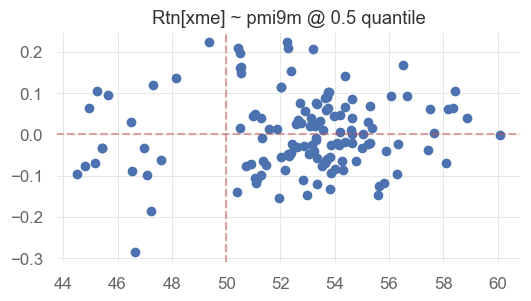

In [198]:
x = 'pmi9m'
y = 'xme'
q = .5

plt.scatter(x=dfX[x], y=dfY[y]);
plt.axhline(y=0, color='r', linestyle='--', alpha=.5);
# plt.axvline(x=dfX[x].quantile(q), color='r', linestyle='--', alpha=.5);
plt.axvline(x=50, color='r', linestyle='--', alpha=.5);

plt.title(f"Rtn[{y}] ~ {x} @ {q} quantile");

In [33]:
dfY.dropna()

,spy,agg,xop,xme,xhb,gld,bil,tip,spts,spti,naivevol,6040
refmonthyear,,,,,,,,,,,,
JAN.2012,0.029961,0.009270,-0.001281,0.048946,0.074841,0.085877,0.000000,0.023232,-0.001988,0.007057,0.009672,0.021760
FEB.2012,0.034347,0.001628,0.086845,-0.058161,0.046258,-0.031080,0.000218,-0.005198,-0.000996,-0.004410,0.009681,0.021619
MAR.2012,0.026843,-0.003718,-0.055190,-0.049921,0.065631,-0.026949,0.000000,-0.006166,-0.001996,-0.004108,0.000764,0.015239
APR.2012,-0.013889,0.008940,-0.025583,-0.042112,0.015573,-0.006505,0.000436,0.012720,0.003666,0.009411,-0.008083,-0.005421
MAY.2012,-0.065866,0.011149,-0.158975,-0.193119,-0.049128,-0.060129,0.000000,0.019069,0.001993,0.008198,-0.006904,-0.037004
...,...,...,...,...,...,...,...,...,...,...,...,...
AUG.2023,-0.013429,0.000310,0.042929,-0.023081,-0.022936,-0.002438,0.004703,-0.002164,0.004880,0.001427,-0.108472,-0.011405
SEP.2023,-0.049208,-0.020825,-0.024127,-0.009481,-0.089072,-0.048082,0.003826,-0.014068,-0.000348,-0.013968,-0.081808,-0.045002
OCT.2023,-0.021319,-0.008805,0.015667,-0.031715,-0.053021,0.085116,0.004156,-0.001166,0.003845,-0.003294,0.078519,-0.019429


In [136]:
from collections import defaultdict, Counter
# for each ticker in dfY, create a count of  how many times there are positive returns 
# when the x variable is above the q quantile
def make_quantile_counts(dfX, dfY, x, q=.5, 
                         use_trailing_quantile=True, 
                         lagperiods=0,
                         thresh=None, 
                         return_type="dataframe"):
    counts = defaultdict(Counter)
    
    if thresh is None:
        thresh = dfX[x].quantile(q)
        
    for t in dfY.columns:
        for i in range(len(dfX)):
            # if dfX.iloc[i][x] > dfX[x].quantile(q):
            if dfX.iloc[i][x] > thresh:
                if lag(dfY, lagperiods).iloc[i][t] > 0:
                    counts[t]['pos'] += 1
                else:
                    counts[t]['neg'] += 1

    if return_type == "dataframe":
        df = pd.DataFrame(counts).reset_index().rename(columns={'index': 'posneg'})
        df['indicator'] = x
        df['lag'] = f"lag {lagperiods}"
        return df
        
    return counts

def make_freq_table(dfcounts):
    return dfcounts.groupby(['posneg']).sum().drop(['indicator', 'lag'], axis=1)

def make_prop_table(dfcounts):
    indicator = dfcounts['indicator'].iloc[0]
    lagperiods = dfcounts['lag'].iloc[0]
    totals = dfcounts.groupby(['posneg']).sum().drop(['indicator', 'lag'], axis=1).sum()
    prop_table = (dfcounts.groupby(['posneg']).sum().drop(['indicator', 'lag'], axis=1) / totals).apply(lambda x: np.round(x * 100, 0))
    prop_table['indicator'] = indicator
    prop_table['lag'] = lagperiods
    
    return prop_table

In [59]:
import datatable as dt

In [156]:
# Contemporaneous counts & proportion tables
lags = range(13)
proptables = {}
for l in lags:
    
    pmi_counts = make_quantile_counts(dfX, dfY, lagperiods=-l, x='pmpmi', thresh=.5)
    nmi_counts = make_quantile_counts(dfX, dfY, lagperiods=-l, x='pmnmi', thresh=.5)
    cpi_counts = make_quantile_counts(dfX, dfY, lagperiods=-l, x='cpiyoy', q=.5)
    cpi_surprise_counts = make_quantile_counts(dfX, dfY, lagperiods=-l, x='cpiyoy.surprise', thresh=0)

    pmi_prop = make_prop_table(pmi_counts)
    nmi_prop = make_prop_table(nmi_counts)
    cpi_prop = make_prop_table(cpi_counts)
    cpi_surprise_prop = make_prop_table(cpi_surprise_counts)

    proptable = pd.concat([pmi_prop, nmi_prop, cpi_prop, cpi_surprise_prop]).reset_index().set_index(['indicator', 'posneg', 'lag']).reset_index()
    proptables[l] = proptable
    

In [157]:
proptable = pd.concat(proptables)
proptable.to_clipboard()

In [200]:
# Generally accepted that if PMI values are above 50, then the economy is expanding. So when PMI is above 50, buy
head(dfX)

,cpi.refdate,cpi.pubdate,cpiyoy1m,cpiyoy3m,cpiyoy6m,cpiyoy9m,cpiyoy12m,cpiyoy1mdt,cpiyoy3mdt,cpiyoy6mdt,...,pmi3m,pmi6m,pmi9m,pmi12m,pmi1mdt,pmi3mdt,pmi6mdt,pmi9mdt,pmi12mdt,pmiact
refmonthyear,,,,,,,,,,,,,,,,,,,,,
APR.2013,2013-04-30,2013-05-21,1.361924,2.045935,1.936189,2.425523,3.497,2013-05-31,2013-07-31,2013-10-31,...,51.453,52.008,53.341,52.556,2013-05-31,2013-07-31,2013-10-31,2014-01-31,2014-04-30,51.0
APR.2014,2014-04-30,2014-05-20,2.067818,1.659554,2.370570,2.605932,2.040,2014-05-31,2014-07-31,2014-10-31,...,55.089,53.878,55.024,53.463,2014-05-31,2014-07-31,2014-10-31,2015-01-31,2015-04-30,56.6
APR.2015,2015-04-30,2015-05-27,-0.143089,-0.426827,-0.466850,2.481655,1.758,2015-05-31,2015-07-31,2015-10-31,...,53.111,52.675,53.292,52.315,2015-05-31,2015-07-31,2015-10-31,2016-01-31,2016-04-30,51.9
APR.2016,2016-04-30,2016-05-20,1.157585,1.163650,1.650565,1.800750,1.291,2016-05-31,2016-07-31,2016-10-31,...,51.921,50.928,50.521,51.067,2016-05-31,2016-07-31,2016-10-31,2017-01-31,2017-04-30,51.3
APR.2017,2017-04-30,2017-05-17,1.910023,2.077399,1.960446,1.512517,2.052,2017-05-31,2017-07-31,2017-10-31,...,54.967,54.347,54.146,53.479,2017-05-31,2017-07-31,2017-10-31,2018-01-31,2018-04-30,55.8


# CPI vs Bond/Stock Returns

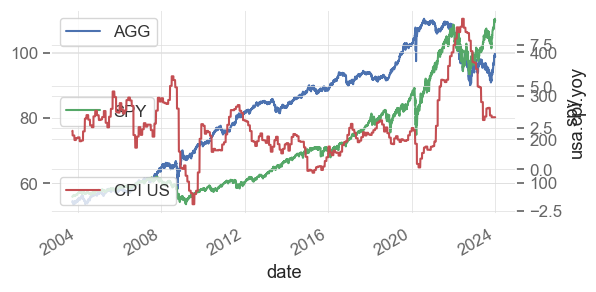

In [53]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
df['agg'].plot(ax=ax1, label='AGG')
ax1.legend(loc='upper left')
sb.lineplot(data=df, x=df.index, y='spy', ax=ax2, c='g', label='SPY')
ax2.legend(loc='center left')
sb.lineplot(data=df, x=df.index, y='usa.cpi.yoy', ax=ax3, c='r', label='CPI US')
ax3.legend(loc='lower left');

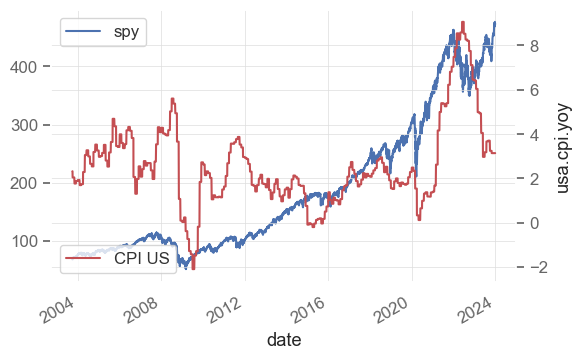

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df['spy'].plot(ax=ax1, label='spy')
ax1.legend(loc='upper left')
sb.lineplot(data=df, x=df.index, y='usa.cpi.yoy', ax=ax2, c='r', label='CPI US')
ax2.legend(loc='lower left')

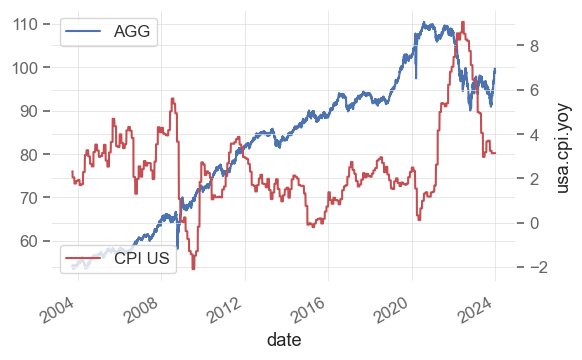

In [9]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df['agg'].plot(ax=ax1, label='AGG')
ax1.legend(loc='upper left')
sb.lineplot(data=df, x=df.index, y='usa.cpi.yoy', ax=ax2, c='r', label='CPI US')
ax2.legend(loc='lower left')

<Axes: xlabel='None', ylabel='AGG'>

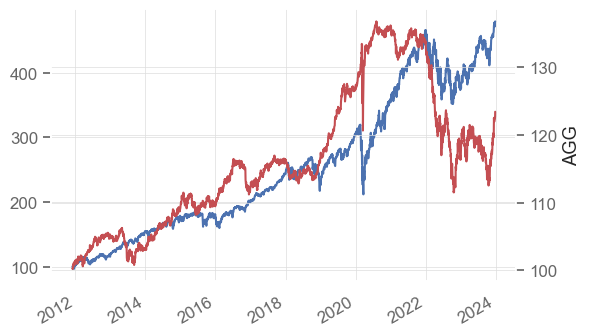

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
dftotrtn['SPY'].plot(ax=ax1)
sb.lineplot(data=dftotrtn, x=dftotrtn.index, y='AGG', ax=ax2, c='r')

## Plot portfolios

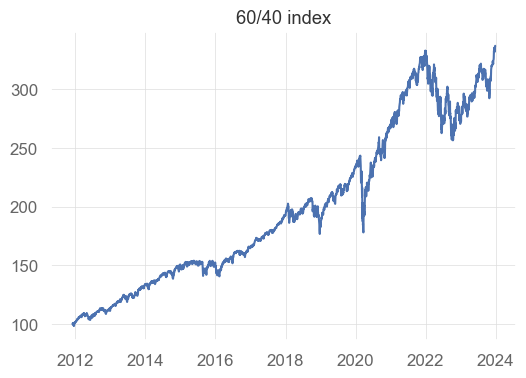

In [12]:
# 60/40
sb.lineplot(data=index6040);
plt.title("60/40 index");


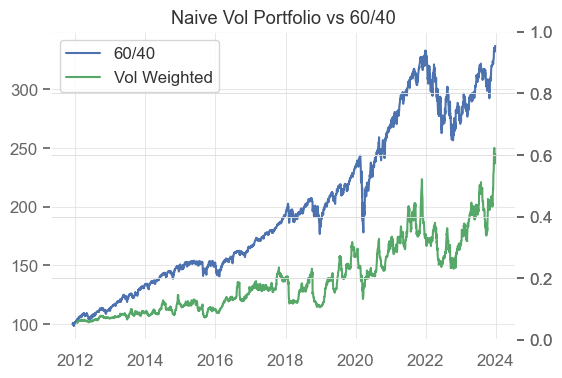

In [13]:
# Vol weighted portfolio

fig, ax1 = plt.subplots(sharex=True)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# df['agg'].plot(ax=ax1, label='AGG')
# ax1.legend(loc='upper left')
# sb.lineplot(data=df, x=df.index, y='spy', ax=ax2, c='g', label='SPY')
# ax2.legend(loc='center left')
# sb.lineplot(data=df, x=df.index, y='usa.cpi.yoy', ax=ax3, c='r', label='CPI US')
# ax3.legend(loc='lower left');


# sb.lineplot(data=vol_tr);
# plt.title("Naive Vol Weighted Portfolio");


sb.lineplot(data=index6040, ax=ax1, label='60/40');
sb.lineplot(data=vol_tr, ax=ax1, label='Vol Weighted', color='g');
# sb.lineplot(data=df[df.index >= dftotrtn.index[0]], x=df.index, y='usa.cpi.yoy', ax=ax3, label='CPI', color='r');
# ax3.plot(df[df.index >= dftotrtn.index[0]].index, df[df.index >= dftotrtn.index[0]]['usa.cpi.yoy'], color='r', label='CPI')
plt.title("Naive Vol Portfolio vs 60/40");


In [14]:
voltr_dd = calc_drawdowns(vol_tr)
print(vol_tr.pct_change().std() * np.sqrt(252) * 100)
print(voltr_dd.min())

16.100715113919563
-17.55342264747206


Text(0.5, 1.0, 'Drawdowns - Naive Vol Weighted Portfolio')

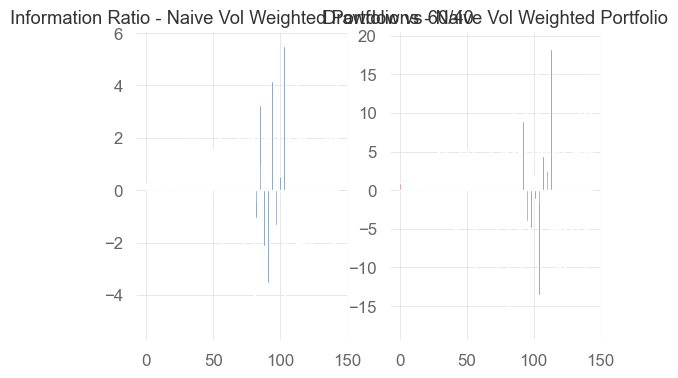

In [15]:
ir = calc_ir(vol_tr, index6040)


plt.subplot(121)
# sb.barplot(ir)
plt.bar(range(len(ir.index)), ir.values, color='b')
plt.title("Information Ratio - Naive Vol Weighted Portfolio vs 60/40")

plt.subplot(122)
# sb.barplot(voltr_dd)
plt.bar(range(len(voltr_dd.index)), voltr_dd.values, color='r')
plt.title("Drawdowns - Naive Vol Weighted Portfolio")

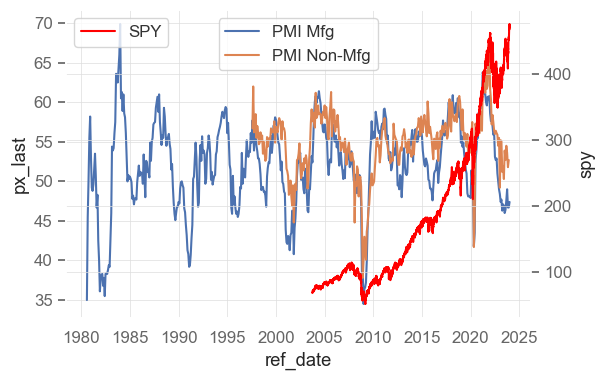

In [16]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ax3 = ax.twinx()
sb.lineplot(data=pmpmi, x='ref_date', y='px_last', ax=ax, label='PMI Mfg'); 
sb.lineplot(data=pmnmi, x='ref_date', y='px_last', ax=ax, label='PMI Non-Mfg'); 
ax.legend();
# sb.lineplot(data=cpi, x='ref_date', y='px_last', ax=ax2, label='CPI', color='red'); 
sb.lineplot(data=df, x=df.index, y='spy', ax=ax2, label='SPY', color='red');
ax2.legend();

# Scatterplots of CPI YoY, PMI vs ETF Returns, Contemporanous

# Plots

In [15]:
import matplotlib.font_manager as font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [17]:
font_dirs = ['c:/users/lcota/downloads/raleway/static']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [58]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.rcParams['figure.figsize'] = (px * 820, px * 350)

In [19]:
old_sans = plt.rcParams["font.sans-serif"]

In [28]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.sans-serif'] = 'Raleway'

In [33]:
# plt.rcParams['font.size'] = 8
# 1066 x 448

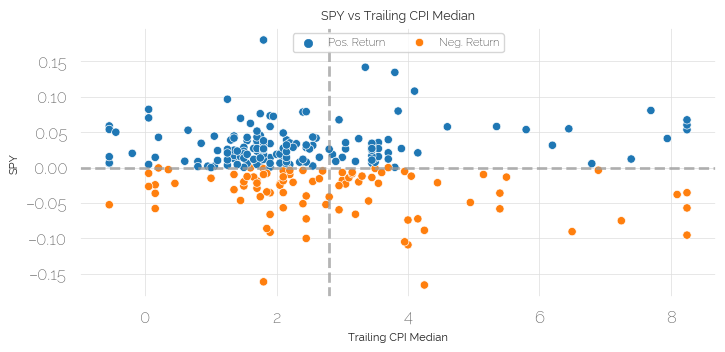

In [59]:
quadrant_plot(cpi, 
              df, 
              xcol='px_last',
              ycol='spy', 
              xcol_name='Trailing CPI Median',
              quantile=.5)

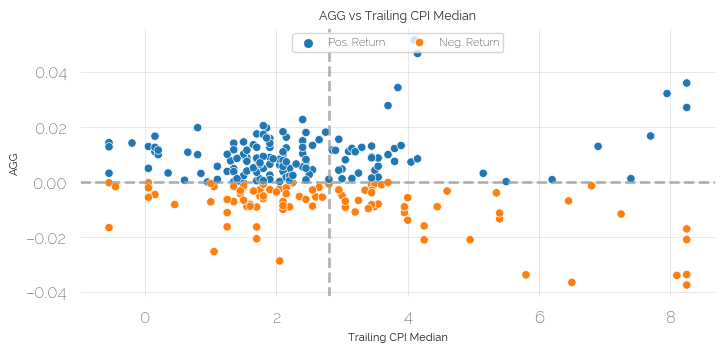

In [60]:
quadrant_plot(cpi, 
              df, 
              xcol='px_last',
              ycol = 'agg',
              xcol_name='Trailing CPI Median',
              quantile=.5)

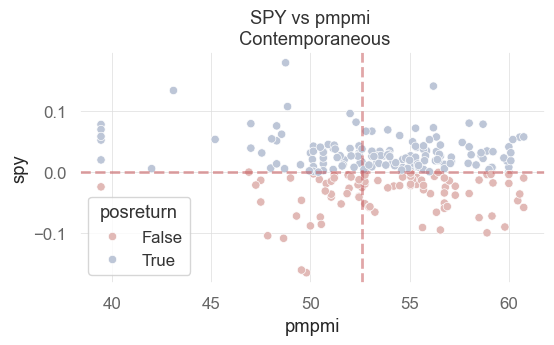

In [105]:
quadrant_plot(pmpmi, 
              df, 
              ycol='spy',
              xcol='px_last',
              xcol_name='pmpmi',              
              quantile=.5)

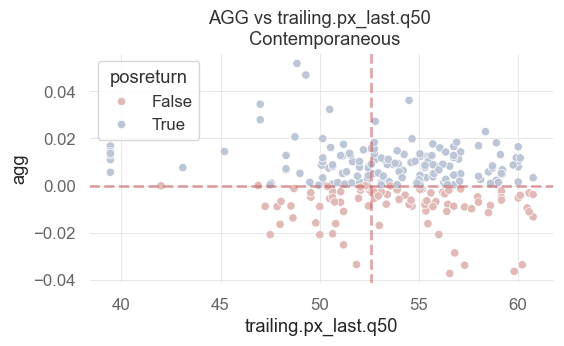

In [110]:
quadrant_plot(pmpmi, 
              df, 
              ycol='agg',               
              xcol='px_last',
              quantile=.5)

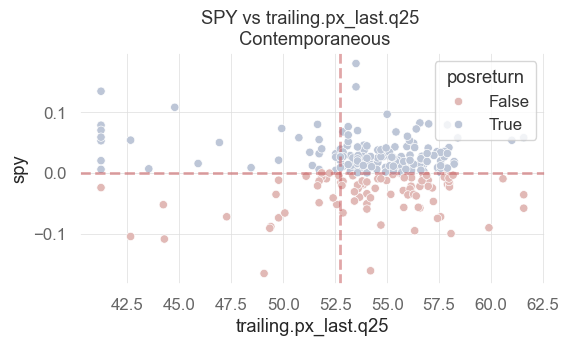

In [117]:
etf = 'spy'
quadrant_plot(pmnmi, 
              df, 
              xcol='px_last',
              ycol='spy', 
              # xlab='PMI NonMfg', 
              # title=f"{etf.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.25)

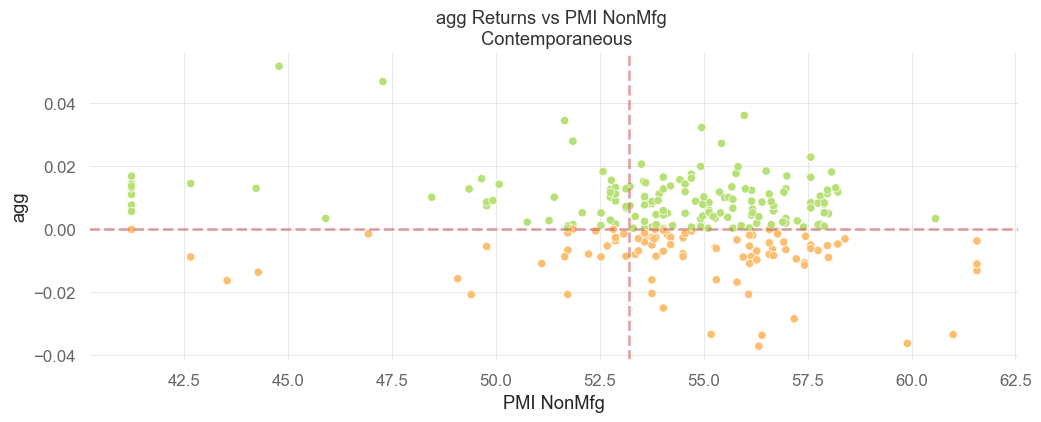

In [ ]:
quadrant_plot(pmnmi, 
              df['agg'], 
              ycol='agg', 
              xlab='PMI NonMfg', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.25)

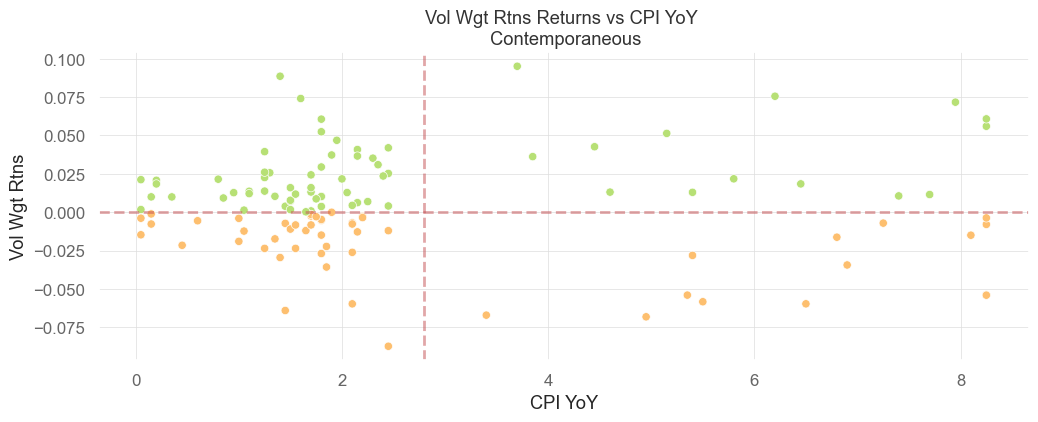

In [ ]:
quadrant_plot(cpi, 
              vol_tr, 
              ycol='Vol Wgt Rtns', 
              xlab='CPI YoY', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.5)

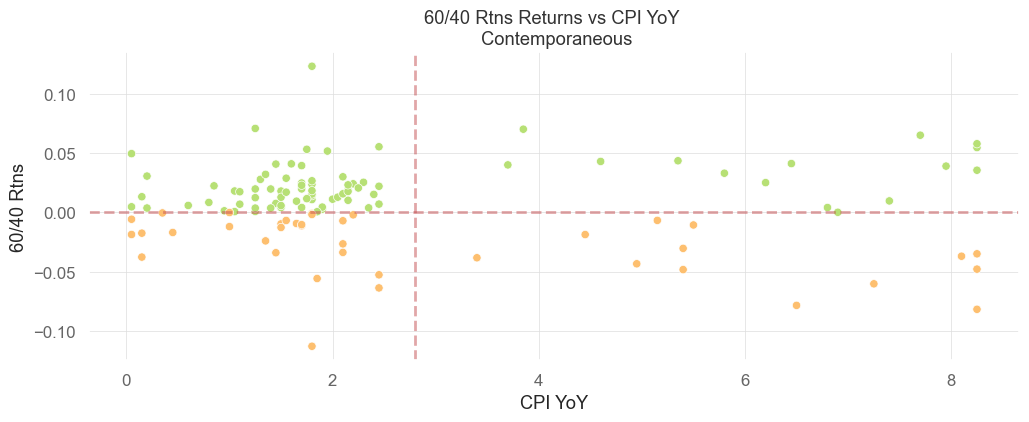

In [ ]:
quadrant_plot(cpi, index6040, 
              ycol='60/40 Rtns', 
              xlab='CPI YoY', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.5)

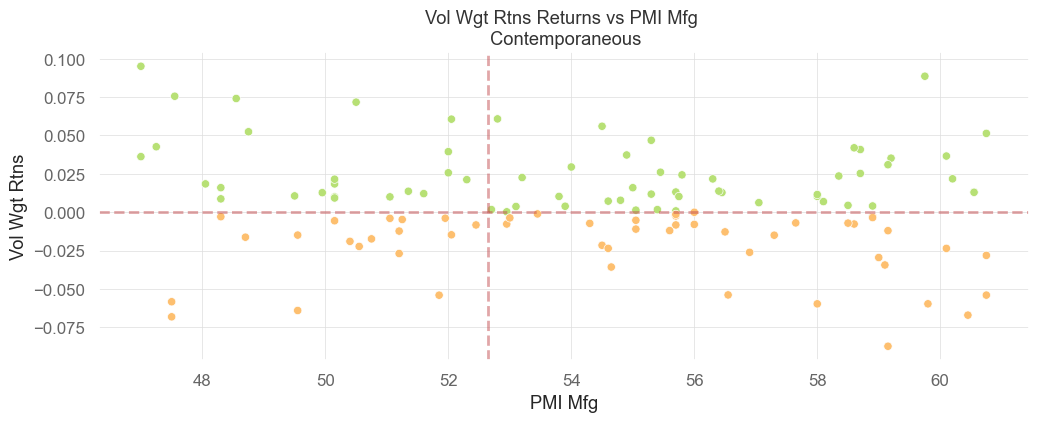

In [ ]:
quadrant_plot(pmpmi, 
              vol_tr, 
              ycol='Vol Wgt Rtns', 
              xlab='PMI Mfg', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.5)

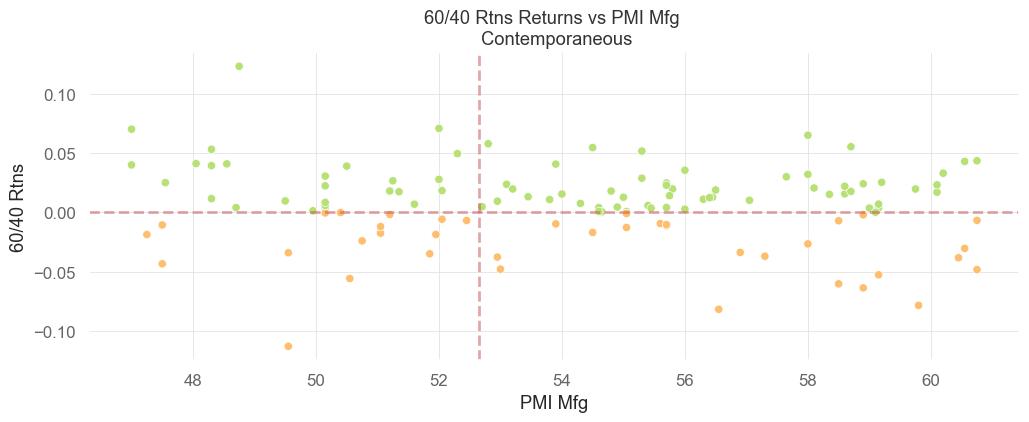

In [ ]:
quadrant_plot(pmpmi, 
              index6040, 
              ycol='60/40 Rtns', 
              xlab='PMI Mfg', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.5)

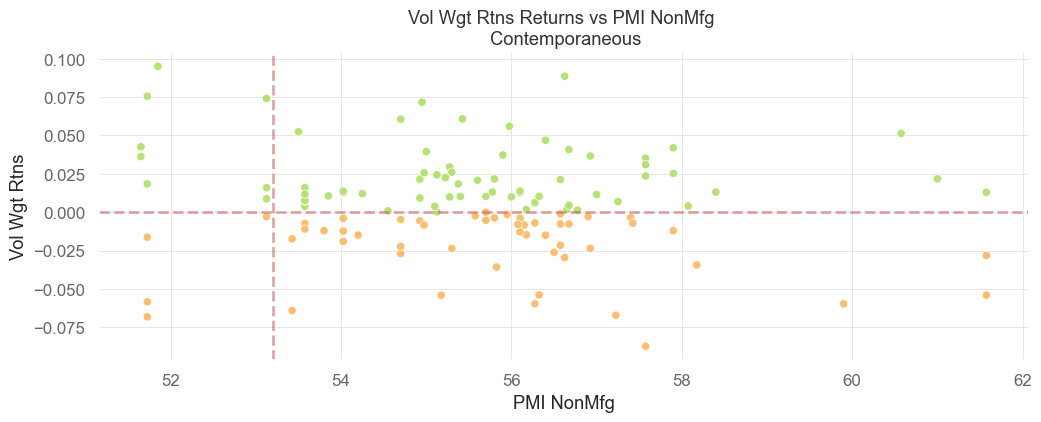

In [ ]:
quadrant_plot(pmnmi, 
              vol_tr, 
              ycol='Vol Wgt Rtns', 
              xlab='PMI NonMfg', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.25)

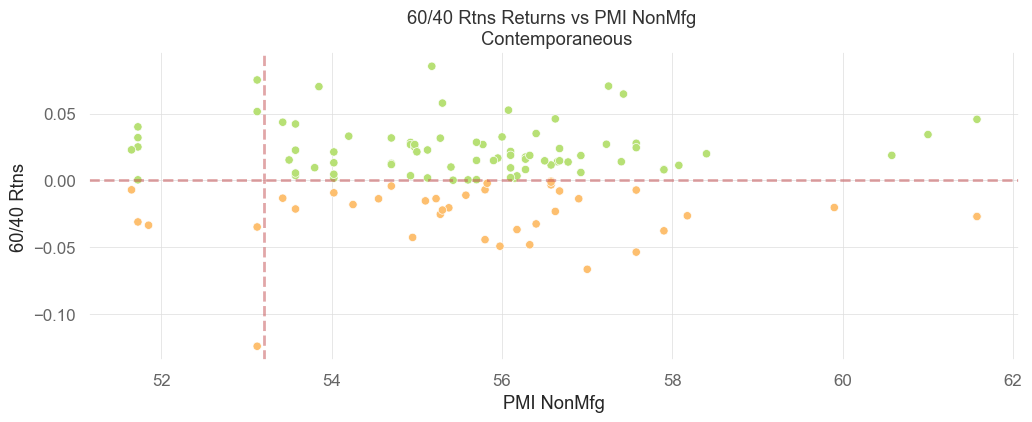

In [ ]:

quadrant_plot(pmnmi, 
              lag(index6040, 60), 
              ycol='60/40 Rtns', 
              xlab='PMI NonMfg', 
              title=f"{ylab.upper()} Returns vs {xlab} \n Contemporaneous", 
              quantile=.25)